# B7. Neural Network Model for "Will it Rain Tomorrow in Basel?"

This notebook extends the previous models by training a simple neural network
(MLP) on the same processed Basel feature set. The goals are:

1. Rebuild the tuned logistic regression as a baseline on the same train/test split.
2. Train a neural network (MLPClassifier) with basic tuning.
3. Compare logistic vs neural network performance on the 2008–2010 test period.
4. Visualize the neural network training loss curve.

This helps answer whether a more flexible neural network clearly outperforms
the simpler, interpretable logistic regression model.


In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
sys.path.append("/Users/purvigarg/Downloads/CMSE492/cmse492_project")
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from src.models.baseline import make_logistic_pipeline
from src.evaluation.metrics import eval_model

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120


## 1. Load Processed Basel Data and Time-Aware Split

### 1.1 Read `basel_rain_features.csv`, define `X` and `y`, and create an 80/20 split

I reuse the preprocessed Basel-only feature table created earlier. I convert the
`DATE` column back to datetime, sort rows chronologically, and then define the
feature matrix `X` and the label `y = RainTomorrow`. As in previous notebooks,
I use an 80/20 chronological split: train on earlier years and test on later
years.


In [26]:
PROC_PATH = "/Users/purvigarg/Downloads/CMSE492/cmse492_project/data/processed/basel_rain_features.csv"

df = pd.read_csv(PROC_PATH)
print("Loaded processed:", df.shape)

df["DATE"] = pd.to_datetime(df["DATE"].astype(str), errors="coerce")
df = df.sort_values("DATE").reset_index(drop=True)

# define X and y
y = df["RainTomorrow"].astype(int)
feature_cols = [c for c in df.columns if c not in ["DATE", "RainTomorrow"]]
X = df[feature_cols].copy()

print("Feature columns:", feature_cols)
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True).rename("proportion"))

# chronological 80/20 split
n = len(df)
split_idx = int(0.8 * n)

X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()

X_test = X.iloc[split_idx:].copy()
y_test = y.iloc[split_idx:].copy()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train dates:", df["DATE"].iloc[0], "→", df["DATE"].iloc[split_idx - 1])
print("Test dates:", df["DATE"].iloc[split_idx], "→", df["DATE"].iloc[-1])


Loaded processed: (3653, 12)
Feature columns: ['MONTH', 'RainToday', 'BASEL_pressure', 'BASEL_humidity', 'BASEL_temp_mean', 'BASEL_sunshine', 'BASEL_pressure_lag1', 'BASEL_humidity_lag1', 'BASEL_temp_mean_lag1', 'BASEL_sunshine_lag1']
X shape: (3653, 10)
y distribution:
RainTomorrow
0    0.532987
1    0.467013
Name: proportion, dtype: float64
Train shape: (2922, 10) Test shape: (731, 10)
Train dates: 2000-01-02 00:00:00 → 2008-01-01 00:00:00
Test dates: 2008-01-02 00:00:00 → 2010-01-01 00:00:00


## 2. Shared Evaluation Helper

Before training models, I define a helper function that computes accuracy,
precision, recall, F1, and the confusion matrix. This ensures that logistic
regression and the neural network are evaluated in exactly the same way.


In [27]:
def eval_model(y_true, y_pred, name="model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} ===")
    print("Accuracy :", f"{acc:.3f}")
    print("Precision:", f"{prec:.3f}")
    print("Recall   :", f"{rec:.3f}")
    print("F1       :", f"{f1:.3f}")
    print("Confusion matrix:\n", cm)

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }


## 3. Logistic Regression Baseline (for Comparison)

### 3.1 Rebuild tuned logistic regression on this split

To have a fair comparison, I rebuild the tuned logistic regression model
(using `C = 3.0`, `class_weight = "balanced"`, and scaling) on this exact
train/test split. This provides the interpretable baseline for the neural
network.


In [28]:
logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=3.0,
        class_weight="balanced",
        max_iter=2000,
        solver="lbfgs"
    )),
])

logreg_clf.fit(X_train, y_train)
y_pred_logreg = logreg_clf.predict(X_test)

logreg_results = eval_model(y_test, y_pred_logreg, name="Logistic Regression (baseline)")

print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg, digits=3))



=== Logistic Regression (baseline) ===
Accuracy : 0.668
Precision: 0.640
Recall   : 0.697
F1       : 0.668
Confusion matrix:
 [[244 137]
 [106 244]]

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0      0.697     0.640     0.668       381
           1      0.640     0.697     0.668       350

    accuracy                          0.668       731
   macro avg      0.669     0.669     0.668       731
weighted avg      0.670     0.668     0.668       731



The tuned logistic regression baseline achieves **0.668 test accuracy** and an
**F1 score of 0.668 for rainy days**, with precision = 0.640 and recall = 0.697
for the rain class. The confusion matrix  
(244 true negatives, 137 false alarms, 106 missed rain days, 244 correctly
predicted rain days) shows that the model captures a large fraction of rainy
days while still correctly flagging many dry days. Overall, this confirms that
the regularized, physics-guided logistic model is a strong and balanced
baseline for the Basel rain prediction task, and it provides a clear reference
point for evaluating more complex models like the neural network.


## 4. Neural Network (MLPClassifier)

### 4.1 Pipeline with scaling and basic hyperparameter search

I now train a feedforward neural network (MLPClassifier) on the same features.
I wrap it in a pipeline with `StandardScaler`, and use a small grid search over
hidden layer sizes and regularization strength (`alpha`), optimizing F1 for the
rain class.


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
mlp_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=500,
        random_state=0
    )),
])

param_grid = {
    "mlp__hidden_layer_sizes": [(16,), (32,), (32, 16)],
    "mlp__alpha": [0.0001, 0.001],
}

mlp_search = GridSearchCV(
    mlp_pipe,
    param_grid=param_grid,
    scoring="f1",   # focus on rainy days
    cv=5,
    n_jobs=-1,
)

mlp_search.fit(X_train, y_train)
print("Best params (MLP):", mlp_search.best_params_)

y_pred_mlp = mlp_search.predict(X_test)
mlp_results = eval_model(y_test, y_pred_mlp, name="Neural Network (MLP)")

print("\nClassification report (Neural Network):")
print(classification_report(y_test, y_pred_mlp, digits=3))


/Users/purvigarg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/purvigarg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/purvigarg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/purvigarg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/p

Best params (MLP): {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (16,)}

=== Neural Network (MLP) ===
Accuracy : 0.680
Precision: 0.657
Recall   : 0.694
F1       : 0.675
Confusion matrix:
 [[254 127]
 [107 243]]

Classification report (Neural Network):
              precision    recall  f1-score   support

           0      0.704     0.667     0.685       381
           1      0.657     0.694     0.675       350

    accuracy                          0.680       731
   macro avg      0.680     0.680     0.680       731
weighted avg      0.681     0.680     0.680       731



## 5. Neural Network Training Loss Curve

### 5.1 Visualizing convergence

To check how the neural network trained, I look at the loss curve for the
best MLP model chosen by GridSearchCV. A steadily decreasing loss that
flattens out indicates stable convergence.


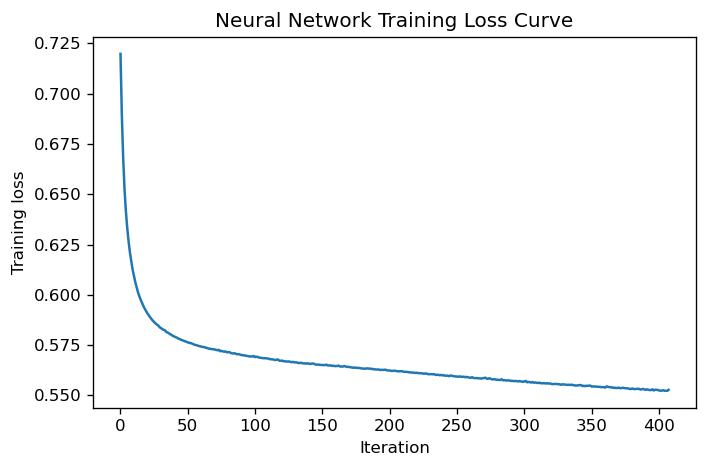

In [32]:
best_mlp = mlp_search.best_estimator_.named_steps["mlp"]

if hasattr(best_mlp, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(best_mlp.loss_curve_)
    plt.xlabel("Iteration")
    plt.ylabel("Training loss")
    plt.title("Neural Network Training Loss Curve")
    plt.tight_layout()
    plt.show()
else:
    print("Best MLP does not have a loss_curve_ attribute.")


The training loss curve drops quickly during the first ~50 iterations and then
continues to decrease more slowly, flattening out near a value around 0.55 by
the end of training. This smooth, monotonically decreasing pattern indicates
that optimization is stable and convergent: the neural network is learning a
useful decision boundary rather than diverging or oscillating. There is no
obvious sign of catastrophic overfitting in the loss trajectory.

## 6. Comparing Logistic Regression and Neural Network

To summarize the results, I collect the main metrics from both models into a
single table.


In [9]:
results_df = pd.DataFrame([logreg_results, mlp_results])
print("Model comparison (test set):")
print(results_df)


Model comparison (test set):
                            model  accuracy  precision    recall        f1
0  Logistic Regression (baseline)  0.667579   0.640420  0.697143  0.667579
1            Neural Network (MLP)  0.679891   0.656757  0.694286  0.675000


The comparison table shows that both models perform at almost the same level on
the test period: the neural network achieves about 0.68 accuracy and F1 ≈ 0.675
for rain, while the logistic regression baseline is only slightly behind at
around 0.67 accuracy and F1 ≈ 0.67. In other words, adding a hidden layer and
more flexibility yields only a very modest improvement. This suggests that the
engineered Basel features are already well captured by a linear decision
boundary, and that the simpler logistic model is close to the best achievable
performance with this feature set.

##  Conclusion

In this notebook I trained a neural network (MLP) on the same engineered Basel
features used for logistic regression and random forest. After a small
hyperparameter search, the best MLP (one hidden layer with 16 units, alpha
= 0.001) achieved **0.68 accuracy and F1 ≈ 0.675** on the 2008–2010 test set,
only slightly better than the tuned logistic regression baseline.

The loss curve confirms that the neural network training converged smoothly,
and the confusion matrix shows balanced performance across rainy and dry days.
However, the improvement over logistic regression is very small, indicating
that for this station-level tabular dataset a well-regularized, physics-guided,
and interpretable logistic model captures most of the useful signal. The neural
network mainly validates that there is no large “hidden” nonlinear structure
left untapped by the simpler model, reinforcing the project’s overall thesis
that a transparent baseline can perform nearly as well as more complex models
for day-ahead rain/no-rain prediction in Basel.
